# Demonstrating the variational autoencoder as a method of druglike molecule discovery ⌬

## Mount Google drive (colab only)

In [ ]:
# https://pubs.acs.org/doi/full/10.1021/acs.jcim.8b00751?src=recsys
# https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb?flush_cache=true
# https://www.borealisai.com/en/blog/tutorial-5-variational-auto-encoders/
# https://www.youtube.com/watch?v=uaaqyVS9-rM

# https://www.acdlabs.com/download/app/physchem/making_sense.pdf
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive/')

## Install RDKit (colab only)

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install sklearn

'wget' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
# sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read raw data (MOSES 2 million SMILES strings) 
### skip if using processed data

In [135]:
import pandas as pd
import keras 
# data = pd.read_csv("2m_moses.csv")
zinc = pd.read_csv("data/250k_smilesOnly.csv") # zinc 250k
#zinc = pd.read_csv("data/2m_moses.csv") # moses 2m
# data = zinc[249480:]
data = zinc
print(zinc.shape)

(249484, 3)


In [ ]:

# alternative 250K SMILES from ZINC dataset
# data = pd.read_pickle("drive/My Drive/drugVAE/pickleData.pkl")

## Import modules

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from matplotlib import pyplot as plt

import pandas as pd


import matplotlib.pyplot as plt
import argparse
import os

from rdkit import Chem
from rdkit.Chem import Draw

from keras import backend as K
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Convolution2D, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import GRU
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import Activation
from keras import objectives
from keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.models import load_model

from scipy.stats import norm
from sklearn import manifold
from sklearn.decomposition import PCA

Using TensorFlow backend.
RDKit WARNING: [14:23:01] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
# tensor cores
from __future__ import absolute_import, division, print_function, unicode_literals

# try:
  # %tensorflow_version only exists in Colab.
#   !pip install -q tf-nightly
# except Exception:
#   pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


Compute dtype: float16
Variable dtype: float32


 ## Check colab GPU device

In [5]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 


['/device:CPU:0', '/device:GPU:0']


In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
#### get specia 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5579755458320327648
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6586313605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4110292176534797440
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5"
]
Default GPU Device: /device:GPU:0


Here is som text that i made

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## One hot encode raw SMILES 
### skip if using processed data

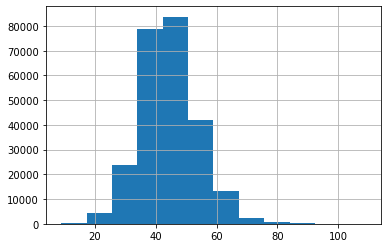

In [136]:
sortedData = data
sortedData['length'] = sortedData['smiles'].str.len()
sortedData.sort_values('length', ascending=False, inplace=True)
sortedData.to_csv("sortedData_with@.csv")
hist = sortedData.length.hist(bins=12)

In [97]:
sortedData = pd.read_csv('sortedData.csv')

(191114, 4)


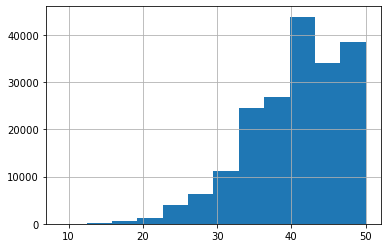

In [139]:
data = sortedData[sortedData['length'] <= 50]
print(data.shape)
data.length.hist(bins=12)


In [144]:
# get special molecules
print(data.head())
specials = data[data['misc'] != 'train']
print(specials)

        Unnamed: 0                                             smiles   misc  length
2153          2153  C[C@H](CCc1ccc2c(c1)OCO2)[NH2+][C@@H](CO)c1ccc...  train      50
107056      107056  COc1ccccc1[C@H]1C[C@@H]1C(=O)NNC(=O)CNc1ccc(C)...  train      50
140475      140475  C/C(=N/NS(=O)(=O)c1ccccc1)c1cccc(NC(=O)C2CCCCC...  train      50
82443        82443  C[C@@H](Oc1ccc(C#N)cc1)C(=O)Oc1cccc(NC(=O)C2CC...  train      50
96337        96337  C[NH2+][C@H](C)C(C)(C)C[NH+](C)[C@H]1CCC[C@H](...  train      50
        Unnamed: 0                                  smiles            misc  length
249483      249482  CCN(CC)CCC[C@@H](C)Nc1ccnc2cc(Cl)ccc12     chloroquine      38
249470      249469     CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21        diazepam      35
249469      249468     NC(=O)C[S@@](=O)C(c1ccccc1)c1ccccc1       modafinil      35
249467      249466     C[C@@H](CN1c2ccccc2Sc2ccccc21)N(C)C    promethazine      35
249463      249462      COc1cc(CNC(=O)CCCC/C=C/C(C)C)ccc1O       capsaicin 

In [145]:
data = specials
print(data)

        Unnamed: 0                                  smiles            misc  length
249483      249482  CCN(CC)CCC[C@@H](C)Nc1ccnc2cc(Cl)ccc12     chloroquine      38
249470      249469     CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21        diazepam      35
249469      249468     NC(=O)C[S@@](=O)C(c1ccccc1)c1ccccc1       modafinil      35
249467      249466     C[C@@H](CN1c2ccccc2Sc2ccccc21)N(C)C    promethazine      35
249463      249462      COc1cc(CNC(=O)CCCC/C=C/C(C)C)ccc1O       capsaicin      34
249468      249467        CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21  chlorpromazine      32
249472      249471          CC(C)Cc1ccc([C@H](C)C(=O)O)cc1       ibuprofen      30
249459      249458           COc1ccc2[nH]cc(CCNC(C)=O)c2c1       melatonin      29
249460      249459              O=C(O)CC(O)(CC(=O)O)C(=O)O         citrate      26
249457      249457              Cn1c(=O)c2c(ncn2C)n(C)c1=O        caffeine      26
249456      249456                CCNC(=O)CC[C@H](N)C(=O)O        theanine      24
2494

In [146]:
# One hot encoding

SMILE_CHARSET = [' ',
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                  'R', 'S', 'T', 'V', 'X', 'Z',
                  '[', '\\', ']',
                  'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                  't', 'u']

# SMILE_CHARSET = [
#     ' ', '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
#     '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
#     'o', 'n', 'p', 's', 'r'
# ]
SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
    'o', 'n', 's', 'r', 'P'
] # use this for original smiles 250k

# SMILE_CHARSET = [
#     '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
#     '=', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
#     'o', 'n', 's', 'r', 'P'
# ] # use this for  smiles 250k WITH REMOVED @

# SMILE_CHARSET = [
#     ')', '(', '-', '1', '3', '2', '5', '4', '6',
#     '=', 'C', 'B', 'F', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
#     'o', 'n', 's', '#', 'r'
# ] # use this for moses 


# The set is based on the ZINC Clean Leads collection. 
# It contains 4,591,276 molecules in total, filtered by molecular weight in the range from 250 to 350 Daltons, a number of rotatable bonds not greater than 7, and XlogP less than or equal to 3.5. 
# We removed molecules containing charged atoms or atoms besides C, N, S, O, F, Cl, Br, H or cycles longer than 8 atoms. The molecules were filtered via medicinal chemistry filters (MCFs) and PAINS filters.


print(len(SMILE_CHARSET))
SMILE_CHARSET = ''.join(SMILE_CHARSET)
print(SMILE_CHARSET)
# print(SMILE_CHARSET)
# each molecule is represented as a 35x109 matrix

MAX_MOLSIZE = max(data['smiles'].str.len())
MAX_MOLSIZE = 50

# MAX_MOLSIZE=109
print(MAX_MOLSIZE)
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
# print(SMILE_to_index)

smiles_onehot = []
n = 0
for smile in data['smiles']:
    SMILE_encoded = [SMILE_to_index[char] for char in smile]
    # print(SMILE_encoded)
    # one hot encoded
    onehot_encoded = list()
    for value in SMILE_encoded:
#         print(len(SMILE_CHARSET))
        letter = [0 for _ in range(len(SMILE_CHARSET))]
        letter[value] = 1
        onehot_encoded.append(letter)

    # columns are charset, rows are molecule index
    df = pd.DataFrame(onehot_encoded)
    df['PADDING'] = 0
    # PADDING: create an empty dataframe of padding MAX_MOLSIZE-moleculeSize
    if len(data.iloc[n].smiles) < MAX_MOLSIZE:
        # add padding
        temp = pd.DataFrame(np.zeros((MAX_MOLSIZE- len(smile), len(df.columns)-1)))
        temp['PADDING'] = 1
        df = df.append(temp, ignore_index=True)
    smiles_onehot.append(df)
    if (n % 10000 == 0):
        print(n)
    
    n+=1

34
#)(+-/\13254768=@CBFIHONS[]clonsrP
50
0


In [142]:
npData = np.stack(smiles_onehot)
np.save("data/smiles_250k_myDrugs_50max.npy", npData)


## Read processed data (50K one-hot encoded MOSES strings)
### data shape: 500000x52x35 

In [6]:
#npData = np.load("data/smiles_250k_myDrugs_new.npy") # 
npData = np.load("data/smiles_250k_myDrugs_50max.npy")
specials = np.load("data/specials.npy")
# removed@ and specials go together
print(npData.shape)
print(specials.shape)

(191114, 50, 35)
(16, 50, 35)


In [147]:
print(smiles_onehot[6].shape)

npData = np.stack(smiles_onehot)
np.save("data/specials.npy", npData)

(50, 35)


In [92]:
npTemp = np.stack(smiles_onehot)
print(npTemp.shape)
npDatan = np.concatenate((npData, npTemp))


(18, 50, 34)


In [65]:
np.save("data/smiles_250k_myDrugs_new.npy", npDatan)

## Set training/test data

In [8]:
# x_train = np.array(npData[0:10000])
x_train = npData[0:30000]
x_test = npData[0:30000]
x_train = np.concatenate((x_train, specials)) # use for adding your own molecules
x_test = x_train
print(x_test.shape)
# x_train = npData
# x_test = npData
# x_test = x_test.reshape(10029, 109, 35).astype('float32') / 255
# x_train = x_train.reshape(10029, 109, 35).astype('float32') / 255

# y_train = np.array(npData[4000:5000]) # these are unused
# y_test = np.array(npData[4000:5000]) # these are unused

(30016, 50, 35)


In [112]:
x_train.shape

(10018, 50, 34)

## Variational autoencoder
#### 3-layer CNN encoder, 3-layer GRU decoder

In [9]:
### with tf.device('/gpu:0'):

original_dim = (x_test.shape[1], x_test.shape[2]) # 52 x 35
input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 512
batch_size = 512
epochs = 40000
epsilon_std = 1.0
print(original_dim)
SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
    'o', 'n', 's', 'r', 'P'
]
SMILE_CHARSET = [
'#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
'=', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
'o', 'n', 's', 'r', 'P'
]
max_length = len(SMILE_CHARSET)+1



# taken from https://blog.keras.io/building-autoencoders-in-keras.html
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_vari = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_vari) * epsilon

def vae_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mu) - K.exp(z_log_var), axis = -1)
    return xent_loss + kl_loss

K.clear_session()

# encoder: CNN
E_Input = Input(shape=(original_dim), name="encoder_input")

#     E_Conv0 = Convolution1D(9, 9, activation = 'relu', name='conv_1')(E_Input)
#     E_Conv1 = Convolution1D(9, 9, activation = 'relu', name='conv_2')(E_Conv0)
#     E_Conv2 = Convolution1D(10, 11, activation = 'relu', name='conv_3')(E_Conv1)   
#     E_MP = MaxPooling1D(pool_size=2)(E_Conv2)
#     E_F = Flatten(name='flatten_1')(E_MP)
#     E_Output = Dense(latent_dim, activation = 'relu', name='dense_1')(E_F)


E_Conv0 = Convolution1D(1024, 4, activation='relu')(E_Input)
E_Conv1 = Convolution1D(768, 4, activation='relu')(E_Conv0)

E_MP0 = MaxPooling1D(4)(E_Conv1)
E_Conv2 = Convolution1D(640, 4, activation='relu')(E_MP0)
E_Conv3 = Convolution1D(512, 4, activation='relu')(E_Conv2)
E_MP1 = GlobalAveragePooling1D()(E_Conv3)
#     E_F = Flatten(name='flatten_1')(E_Conv3)
E_Output = Dense(latent_dim, activation = 'relu', name='dense_1', dtype = 'float32')(E_MP1)

# This is what makes the autoencoder "variational" (part of encoder)
z_mu = Dense(latent_dim, name='z_mean')(E_Output)
z_log_var = Dense(latent_dim, name='z_log_var')(E_Output)
z = Lambda(sampling, output_shape=(latent_dim,), dtype = 'float32')([z_mu, z_log_var])


# decoder: GRU
D_Input = Input(shape=(latent_dim,), name = "decoder_input")
D_RV = RepeatVector(x_train.shape[1], name='repeat_vector')(D_Input)
D_G0 = GRU(512, return_sequences = True, name='gru_1')(D_RV)
D_G0 = GRU(576, return_sequences = True, name='gru_1')(D_RV)
D_G1 = GRU(640, return_sequences = True, name='gru_2')(D_G0)
D_G2 = GRU(704, return_sequences = True, name='gru_3')(D_G1)
D_Output = TimeDistributed(Dense(x_train.shape[2], activation='softmax', dtype = 'float32'), name = 'decoded_mean')(D_G2)

# build encoder and decoder models
Encoder = Model(E_Input, [z_mu, z_log_var, z], name="encoder")
Decoder = Model(D_Input, D_Output, name = "decoder")

# build VAE
x_pred = Decoder(Encoder(E_Input)[2])
vae = Model(inputs=[E_Input], outputs=x_pred)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)


### Train VAE ###

from keras.callbacks import History, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
h = History()
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=5, min_lr=0.00000000000001, verbose=1, epsilon=1e-5)

filepath="vaemodels/zinc_10k_mixed/weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('vaemodels/training_zinc_10k_mixed.csv')

callbacks_list = [checkpoint, h, rlr, csv_logger]

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
opt = optimizers.Adam(lr=6.25000029685907e-05, beta_1=0.9, beta_2=0.999, amsgrad=False)

vae.compile(loss=vae_loss, optimizer=opt, metrics = ['accuracy'])
vae.load_weights("vaemodels/zinc_10k_mixed/weights-improvement-42-0.97.hdf5")
# plot_model(vae, to_file='encoder.png', show_shapes=False)
print(vae.summary())

vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                callbacks = callbacks_list,
                validation_data=(x_test, x_test))


(50, 35)


C:\Users\Justin\Anaconda3\envs\my-rdkit-env\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 50, 35)            0         
_________________________________________________________________
encoder (Model)              [(None, 512), (None, 512) 7356800   
_________________________________________________________________
decoder (Model)              (None, 50, 35)            7083747   
Total params: 14,440,547
Trainable params: 14,440,547
Non-trainable params: 0
_________________________________________________________________
None
Train on 30016 samples, validate on 30016 samples
Epoch 1/40000
21504/30016 [====================>.........] - ETA: 46s - loss: 0.3025 - accuracy: 0.9703

InternalError: GPU sync failed

In [ ]:
latest_model = "vaemodels/test/weights-improvement-2213-0.99.hdf5"



# print(K.eval(vae.optimizer.lr))
# vae = load_model(latest_model, custom_objects={"vae_loss":vae_loss}) # vae
vae = load_model(latest_model)
print(vae.get_layer("encoder").summary())
print(vae.get_layer("decoder").summary())
# vae.load_weights(latest_model)

### Use for retrieving decoder/encoder ###
# vae.get_layer('encoder').get_layer('encoder_input').set_weights
# print(vae.summary())
# # build encoder
# Encoder = Model(inputs=vae.input, outputs=vae.get_layer("encoder").get_output_at(-1))
# x =Encoder.predict(x_test)

# build decoder
# Decoder = Model(inputs=vae.get_layer("decoder").get_layer('decoder_input').output, outputs=vae.get_layer("decoder").get_layer('decoded_mean').output)

# # vae.evaluate(x_train[0:2],x_train[0:2])
from keras import optimizers
myLr = 6.25000029685907e-05
opt = optimizers.Adam(lr=myLr, beta_1=0.9, beta_2=0.999, amsgrad=False)


# vae.compile(loss=vae_loss, optimizer=opt, metrics = ['accuracy'])

# print(vae.get_layer('encoder').get_weights())
h = History()
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.000000000000000000000001, verbose=1, epsilon=1e-5)
from keras.callbacks import ModelCheckpoint

filepath="drive/My Drive/vaemodels/nonvae_1000_2/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('drive/My Drive/vae_logs/training.csv')

callbacks_list = [checkpoint, h, rlr, csv_logger]
epochs = 320
vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                callbacks = callbacks_list,
                validation_data=(x_test, x_test))




### Only load model, no training

In [102]:
import keras.backend as K

from keras.models import load_model
# import keras
# tf.reset_default_graph()

vae = load_model('vaemodels/testcnn_40k/weights-improvement-628-0.93.hdf5', custom_objects={'vae_loss':vae_loss})
# vae.fit(x_train, x_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         shuffle=True,
#         callbacks = callbacks_list,
#         validation_data=(x_test, x_test))

In [35]:
vae.load_weights("vaemodels/zinc_10k_mixed/weights-improvement-453-0.97.hdf5")

ValueError: Shapes (512, 1860) and (512, 1728) are incompatible

In [ ]:
print(K.eval(vae.optimizer.lr))

## Generate latent space

In [ ]:
# Get latent space

# get encoder from model
Encoder = Model(inputs=vae.input, outputs=vae.get_layer("encoder").get_output_at(-1))
x = Encoder.predict(x_test)[2] # this is the latent space
# print("latent space shape is ", x.shape)

# get decoder from model
Decoder = Model(inputs=vae.get_layer("decoder").get_layer('decoder_input').output, outputs=vae.get_layer("decoder").get_layer('decoded_mean').output)

decoded = Decoder.predict(x) # this is the decoded latent representation


In [ ]:
# Get latent space

# original_dim = (x_test.shape[1], x_test.shape[2])
# # original_dim = (28, 28)

# input_shape = (original_dim, )
# intermediate_dim = 512
# latent_dim = 256


# # build encoder
# Encoder = Model(inputs=vae.input, outputs=vae.get_layer("encoder").get_output_at(-1))
# x =Encoder.predict(x_test)

# # build decoder
# Decoder = Model(inputs=vae.get_layer("decoder").get_layer('decoder_input').output, outputs=vae.get_layer("decoder").get_layer('decoded_mean').output)

# decoded = Decoder.predict(x)


# Check number/% of molecules successfully reconstructed

In [ ]:
# out is one molecule
def outToSMILES(OUT):
  # SMILE_CHARSET = [' ',
  #                 '#', '%', '(', ')', '+', '-', '.', '/',
  #                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
  #                 '=', '@',
  #                 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
  #                 'R', 'S', 'T', 'V', 'X', 'Z',
  #                 '[', '\\', ']',
  #                 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
  #                 't', 'u', '_']
  SMILE_CHARSET = [
  '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
  '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
  'o', 'n', 's', 'r', 'P', '_'
  ] # use this for original smiles 250k

  #print(len(SMILE_CHARSET))
  maxProbIndexes = (np.argmax(OUT, axis=1))
  #print(maxProbIndexes)
  
  smile = ""
  for i in range(len(maxProbIndexes)):

    smile += SMILE_CHARSET[maxProbIndexes[i]]
    
  return smile
#out = decoded_output[502]
np.set_printoptions(threshold=sys.maxsize)
n=0
c=0
# for decode in x:
#   cand = outToSMILES(decode)
#   #print(cand)
#   cand = str.replace(cand, "_", "")
#   m = Chem.MolFromSmiles(cand,sanitize=False)
#   if m is None:
#     c+=1
# print(c/len(x))
dec = Decoder.predict(x)
print(dec.shape)
# dec = dec[0:50000]

# data['validMolecule']=0
count = 0
for n in range(len(dec)):
  out =dec[n]

  out1 = x_test[n]

  # # out = x_train[0]
  m1 = outToSMILES(out)
  m1 = str.replace(m1, "_", "")
  m2 = outToSMILES(out1)
  m2 = str.replace(m2, "_", "")
  mole1 = Chem.MolFromSmiles(m1)
  
  if mole1:
    #Draw.MolToMPL(mole1)
    count+=1
#     data.loc[n,'validMolecule'] = 1


  # else:
  #   #print(m1, " is incorrect")
print(count, 'molecules valid', '(', count/len(dec), ')')

### oneHotEncodeSMILE and outToSMILES functions

In [52]:
def outToSMILES(OUT):
    # SMILE_CHARSET = [' ',
    #                 '#', '%', '(', ')', '+', '-', '.', '/',
    #                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    #                 '=', '@',
    #                 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
    #                 'R', 'S', 'T', 'V', 'X', 'Z',
    #                 '[', '\\', ']',
    #                 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
    #                 't', 'u', '_']
#     SMILE_CHARSET = [
#       '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
#       '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
#       'o', 'n', 'p', 's', 'r','_']
    SMILE_CHARSET = [
        '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
        '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
        'o', 'n', 's', 'r', 'P', '_'
    ]
    SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
    'o', 'n', 's', 'r', 'P', "_"
    ] # use this for original smiles 250k

    #print(len(SMILE_CHARSET))
    maxProbIndexes = (np.argmax(OUT, axis=1))
    # print(maxProbIndexes)
    #print(maxProbIndexes)

    smile = ""
    for i in range(len(maxProbIndexes)):
        smile += SMILE_CHARSET[maxProbIndexes[i]]

    return smile

def outToSMILES_clean(OUT):
    # SMILE_CHARSET = [' ',
    #                 '#', '%', '(', ')', '+', '-', '.', '/',
    #                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    #                 '=', '@',
    #                 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
    #                 'R', 'S', 'T', 'V', 'X', 'Z',
    #                 '[', '\\', ']',
    #                 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
    #                 't', 'u', '_']
    SMILE_CHARSET = [
        '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
        '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
        'o', 'n', 's', 'r', 'P', "_"
    ] # use this for original smiles 250k

    #print(len(SMILE_CHARSET))
    maxProbIndexes = (np.argmax(OUT, axis=1))
    # print(maxProbIndexes)
    #print(maxProbIndexes)

    smile = ""
    for i in range(len(maxProbIndexes)):
        smile += SMILE_CHARSET[maxProbIndexes[i]]
    smile = smile.replace("_", "")
    return smile


def oneHotEncode(smileStr):
    SMILE_CHARSET = [
        '#', ')', '(', '+', '-', '/', '\\', '1', '3', '2', '5', '4', '7', '6', '8',
        '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', 'c', 'l',
        'o', 'n', 's', 'r', 'P'
    ] # use this for original smiles 250k

    SMILE_CHARSET = ''.join(SMILE_CHARSET)
    # print(SMILE_CHARSET)

   # MAX_MOLSIZE = max(data['smiles'].str.len())
   # MAX_MOLSIZE = 109
    MAX_MOLSIZE=50
    SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
    index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))

    smiles_onehot =''

    SMILE_encoded = [SMILE_to_index[char] for char in smileStr]
    # print(SMILE_encoded)
    # one hot encoded
    onehot_encoded = list()
    for value in SMILE_encoded:
    #         print(len(SMILE_CHARSET))
        letter = [0 for _ in range(len(SMILE_CHARSET))]
        letter[value] = 1
        onehot_encoded.append(letter)

    # columns are charset, rows are molecule index
    df = pd.DataFrame(onehot_encoded)
    df['PADDING'] = 0
    # PADDING: create an empty dataframe of padding MAX_MOLSIZE-moleculeSize
    if len(smileStr) < MAX_MOLSIZE:
        # add padding
        temp = pd.DataFrame(np.zeros((MAX_MOLSIZE- len(smileStr), len(df.columns)-1)))
        temp['PADDING'] = 1
        df = df.append(temp, ignore_index=True)
    smiles_onehot = df
    return smiles_onehot.to_numpy()



### Useful RDKit functions

In [ ]:
# code for obtaining logp and QED using RDKit

import rdkit.Chem.Crippen
from rdkit.Chem.Descriptors import qed
from rdkit.Chem import QED

mole1 = Chem.MolFromSmiles("Cc1nn(N)cc(C2N)c(OC)c2NN2CNc2cc(C)c1")
print("logp: ", rdkit.Chem.Crippen.MolLogP(mole1))
print('qed: ', qed(mole1) )
print(QED.properties(mole1))

## Sample latent space and attempt to generate new molecules

In [50]:
# adds distance from some latent representation of a molecule
# by adding a random normal distribution normalized (to get direction) scaled by distance
def addDistance(z, dist):
    noise = np.random.normal(0, 1, size=z.shape)
    noise = noise / np.linalg.norm(noise)
    return z + noise*dist

# takes in two latent representations of a molecule
# returns their distance
def getDistanceFromTarget(target, z): 
    return np.linalg.norm(target - z , axis=1)

## Sample distribution x distance from a molecule

In [194]:
# Drawing options
from rdkit.Chem.Draw import DrawingOptions
DrawingOptions.atomLabelFontSize = 20
DrawingOptions.dotsPerAngstrom = 30
DrawingOptions.bondLineWidth = 3



(50, 35)
Cc1c(=O)c2c(ncn2C)n(C)c1=O________________________
Cc1c(CO)c2c(ncn2C)n(C)c1=O 0.71273924973255
Cc1c(=O)c2c(ccn2C)C(C)c1OO 2.7490337022496494
Cc1c(=O)c2c(cc2)CCC(C)c1OO 8.53622629595764
Cc1c(CO)c2c(ccn2C)n(C)c1=O 2.4454572648618274
Cc1c(=O)c2c(ccn2C)n(C)c1OO 2.9933054300561945
20 fraction:  0.02


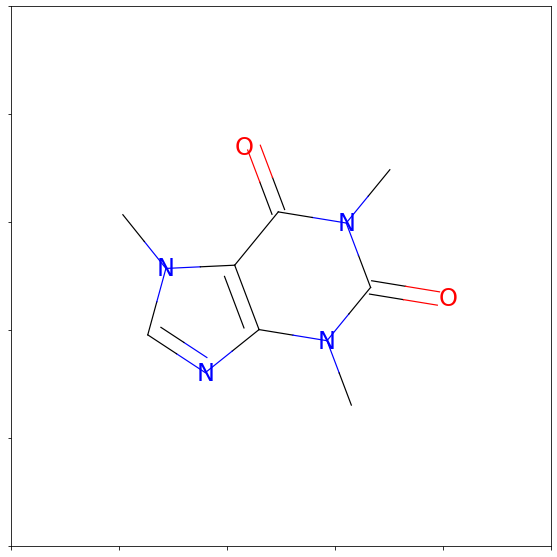

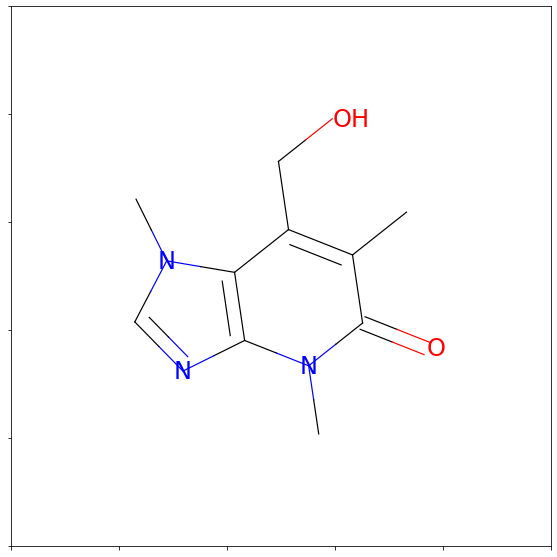

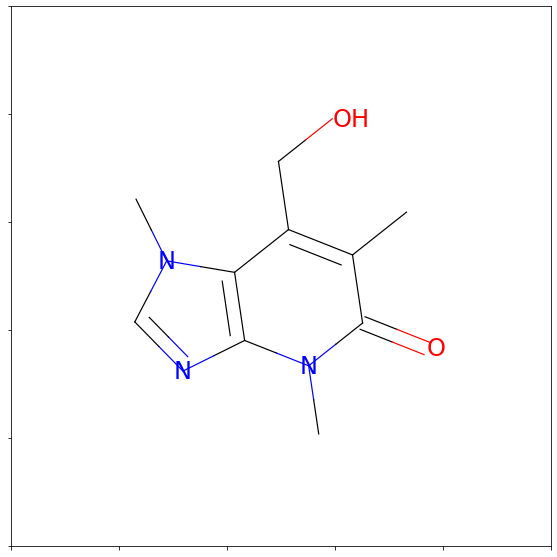

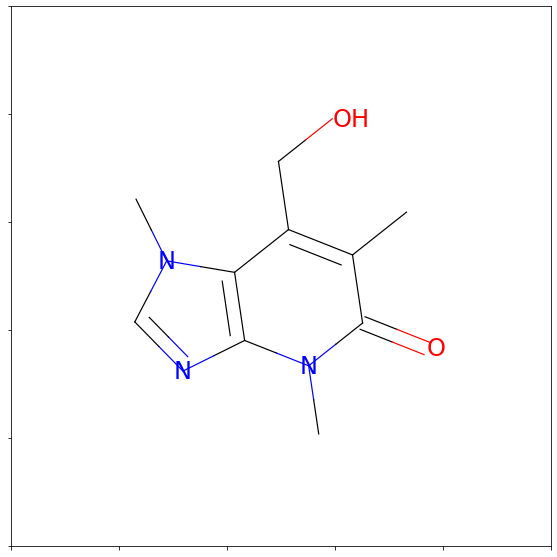

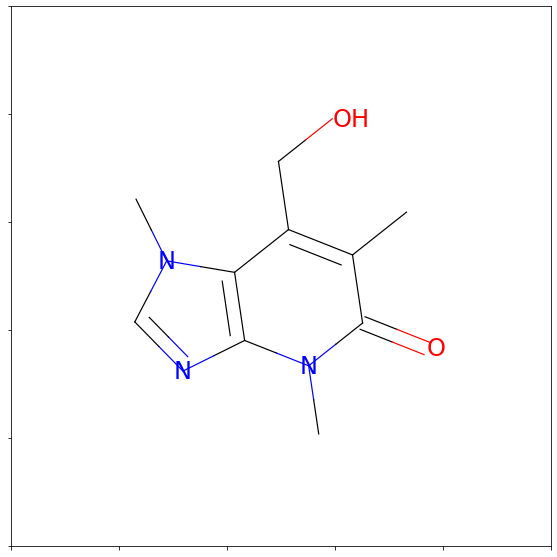

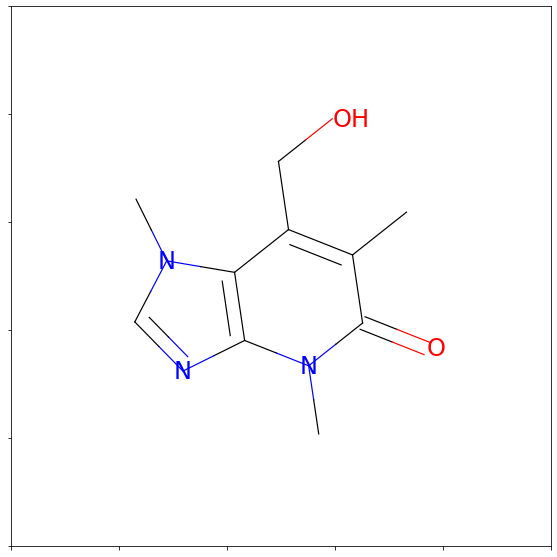

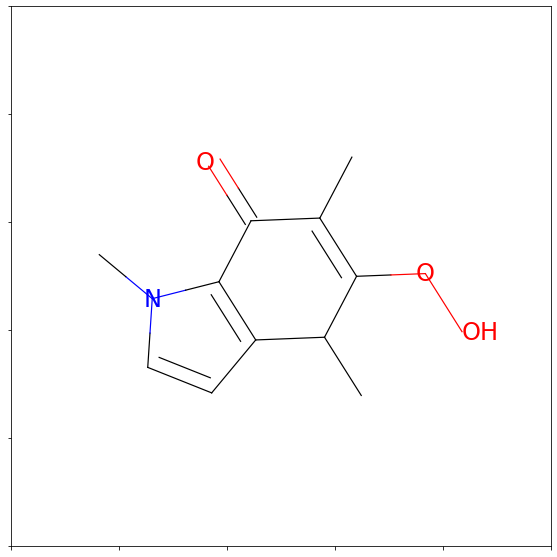

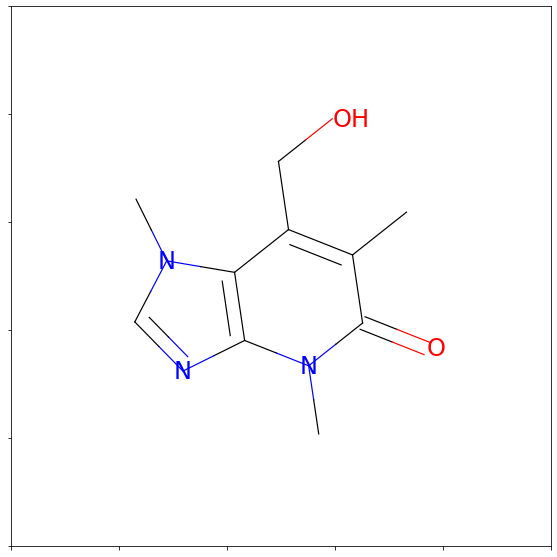

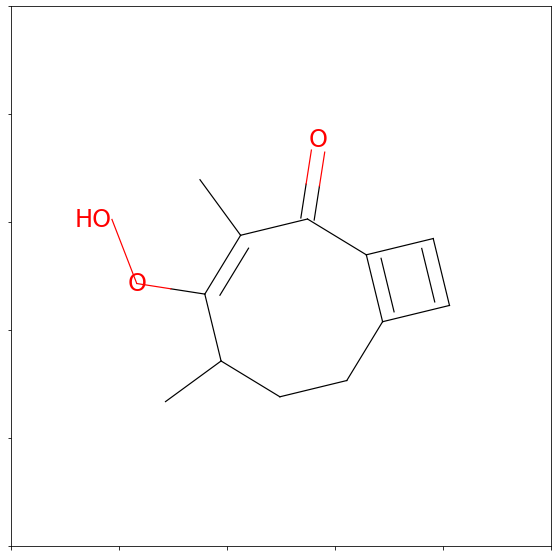

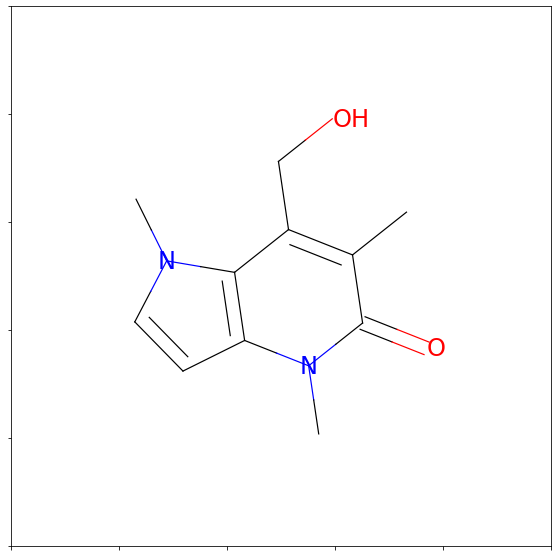

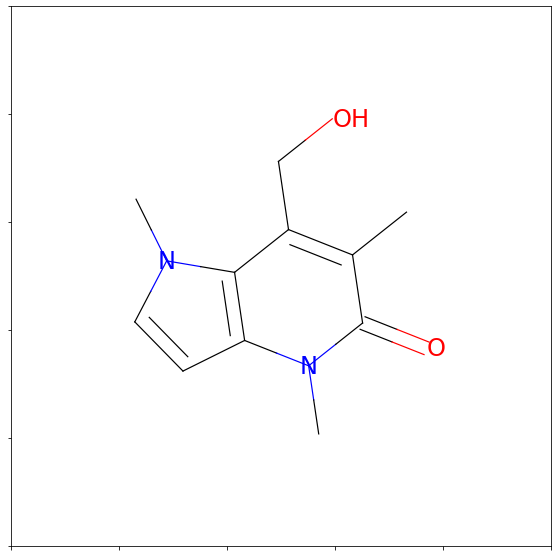

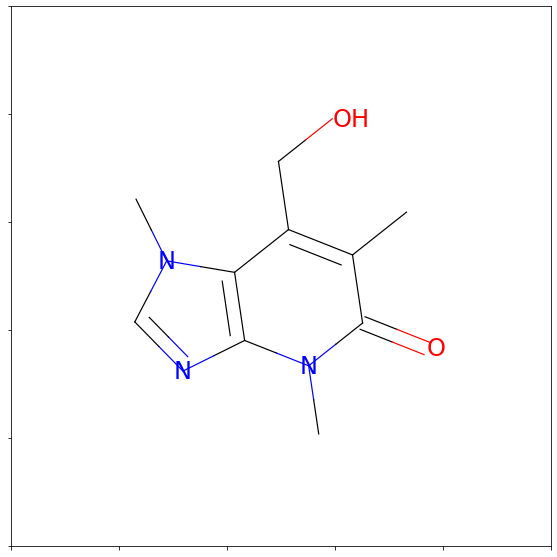

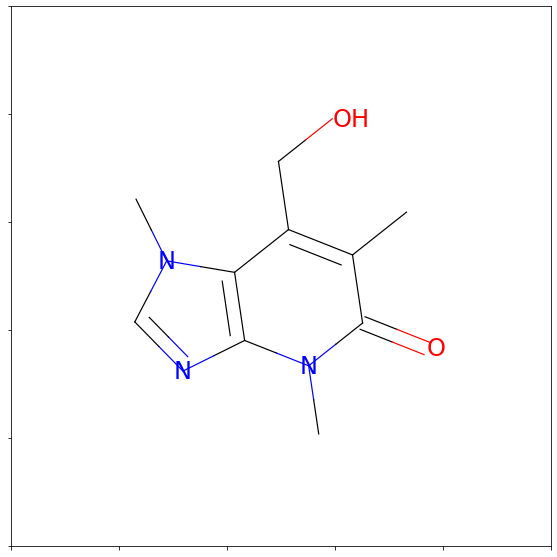

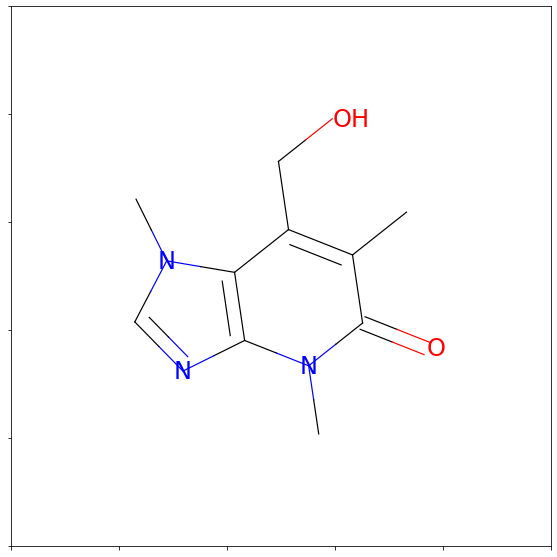

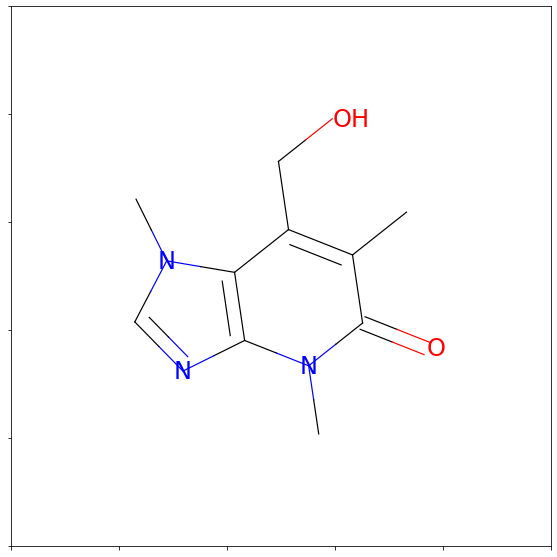

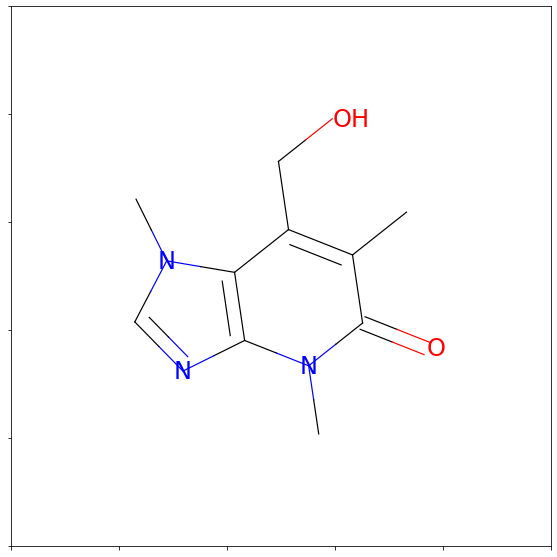

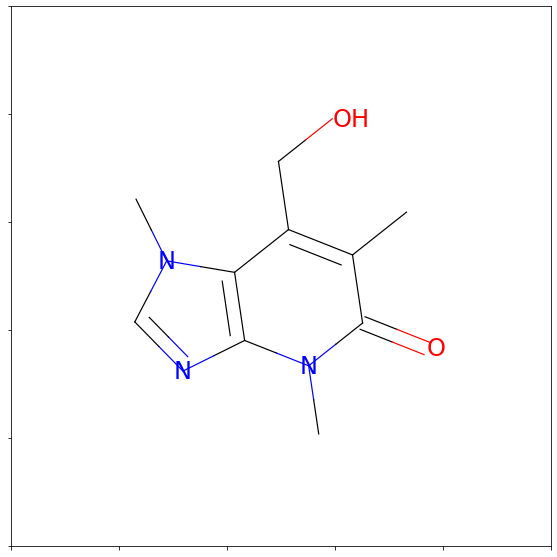

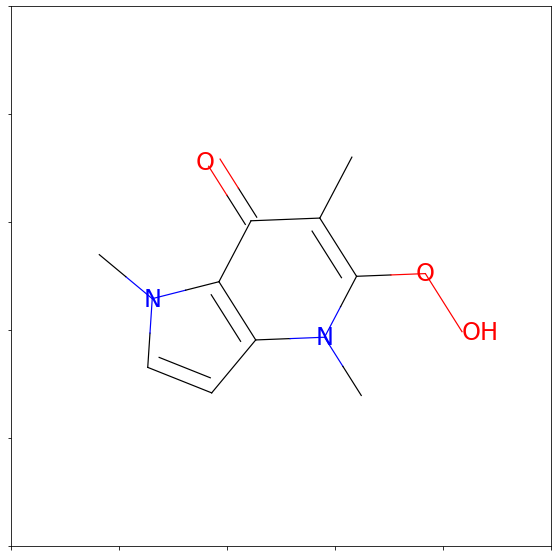

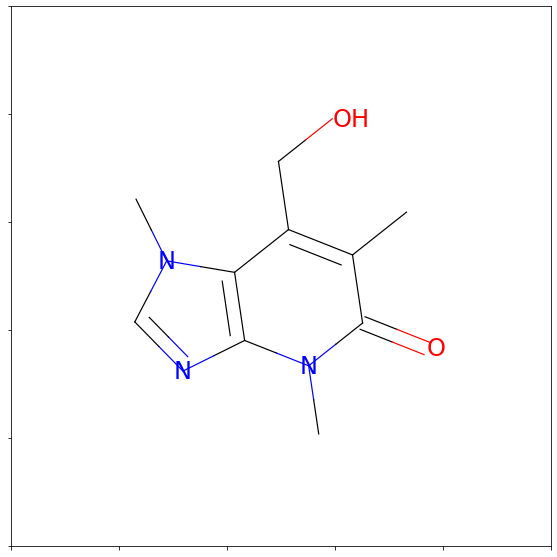

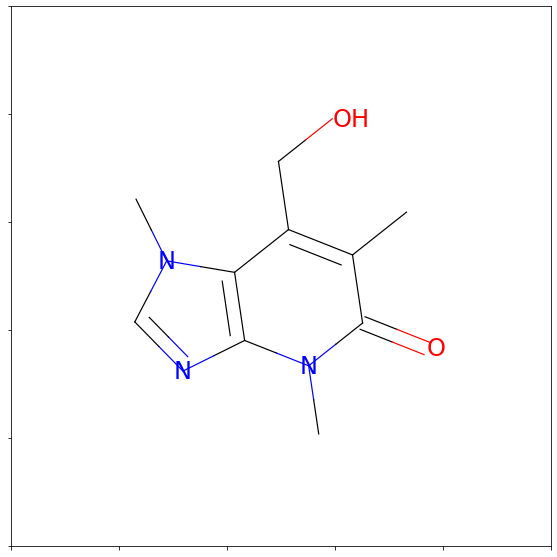

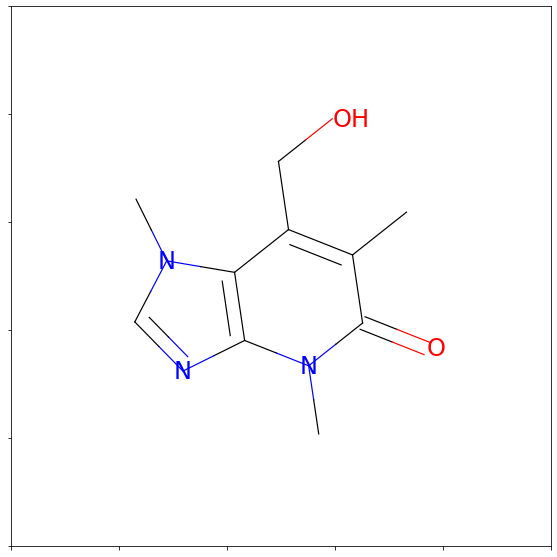

In [66]:
# mole = 'O=C(Nc1ccc(Br)c2cccnc12)C1CC1'
caffeine = "Cn1c(=O)c2c(ncn2C)n(C)c1=O"
chloroquine = "CCN(CC)CCC[C@@H](C)Nc1ccnc2cc(Cl)ccc12"
mole = caffeine
molMol = Chem.MolFromSmiles(mole)
#Draw.MolToFile(molMol, "caffeine.png", size=(1000, 1000), fitImage=True)
#Draw.MolToFile( molMol, "temp.svg", size=(1000, 1000) )
Draw.MolToMPL(molMol) 

# https://github.com/aspuru-guzik-group/chemical_vae/blob/master/examples/intro_to_chemvae.ipynb
# print(x_train[0])
# print(mole)
moleEncode = oneHotEncode(mole)
print(moleEncode.shape)
# print(moleEncode)
# print(outToSMILES(np.expand_dims(moleEncode,axis=0)[0]))
moleEncode = np.expand_dims(moleEncode, axis=0)
x = Encoder.predict(moleEncode)[2] # this is the latent space
de = Decoder.predict(x)
# print(de.shape)
n = 0
dist_attempts = 1000
uniques = []
print(outToSMILES(de[0]))
for i in range(dist_attempts):
    dist = random.uniform(0.0001,10)
    newSmile = outToSMILES_clean(Decoder.predict(addDistance(Encoder.predict(moleEncode)[2],dist))[0])
    if Chem.MolFromSmiles(newSmile):
        newMol = Chem.MolFromSmiles(newSmile)
        Draw.MolToMPL(newMol) 
        if newSmile not in uniques:
            uniques.append(newSmile)
            print(newSmile, dist)
        n+=1
print(n, 'fraction: ', n/dist_attempts)

In [ ]:
np.linalg.norm(x)

## Generate Random Molecules

In [26]:
  # implement something like 
  # https://denouden.dev/VAE-Latent-Space-Explorer/
  
  import random

  count = 0
  attempts = 50000
  for i in range(attempts):
    # figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    z_sample = np.array([np.random.normal(size=512, loc=random.random()*1, scale=4*random.random())])
    x_decoded = Decoder.predict(z_sample)
    
    # print(x_decoded.shape)
    smile  = outToSMILES(x_decoded[0])
    smile = smile.replace("_", "")
    mole1 = Chem.MolFromSmiles(smile)
    

    if mole1:
      print(smile)
      Draw.MolToMPL(mole1)
      count+=1
print(count, 'valid molecules found. Frac valid = ',count/attempts)

KeyboardInterrupt: 

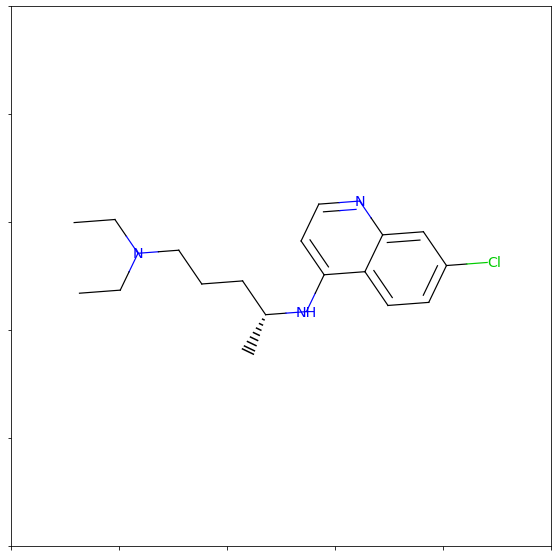

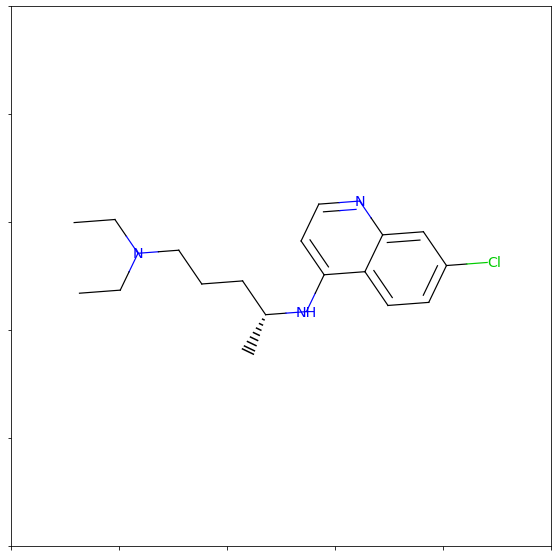

In [28]:
sm = "CCN(CC)CCC[C@@H](C)Nc1ccnc2cc(Cl)ccc12" # chloroquine
Draw.MolToMPL(Chem.MolFromSmiles(sm))

In [21]:
print(x.shape)

(1, 500)


# Visualize latent space using T-SNE

In [24]:
# datrunc = x[0:20000]
print(x.shape)
datrunc = x

tsne = manifold.TSNE(n_components=2,perplexity=40, random_state=0)
X_tsne = tsne.fit_transform(datrunc)


(100029, 500)


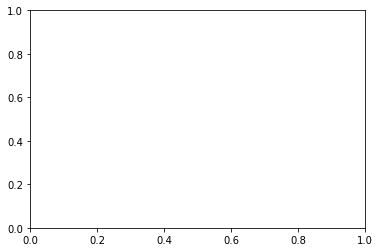

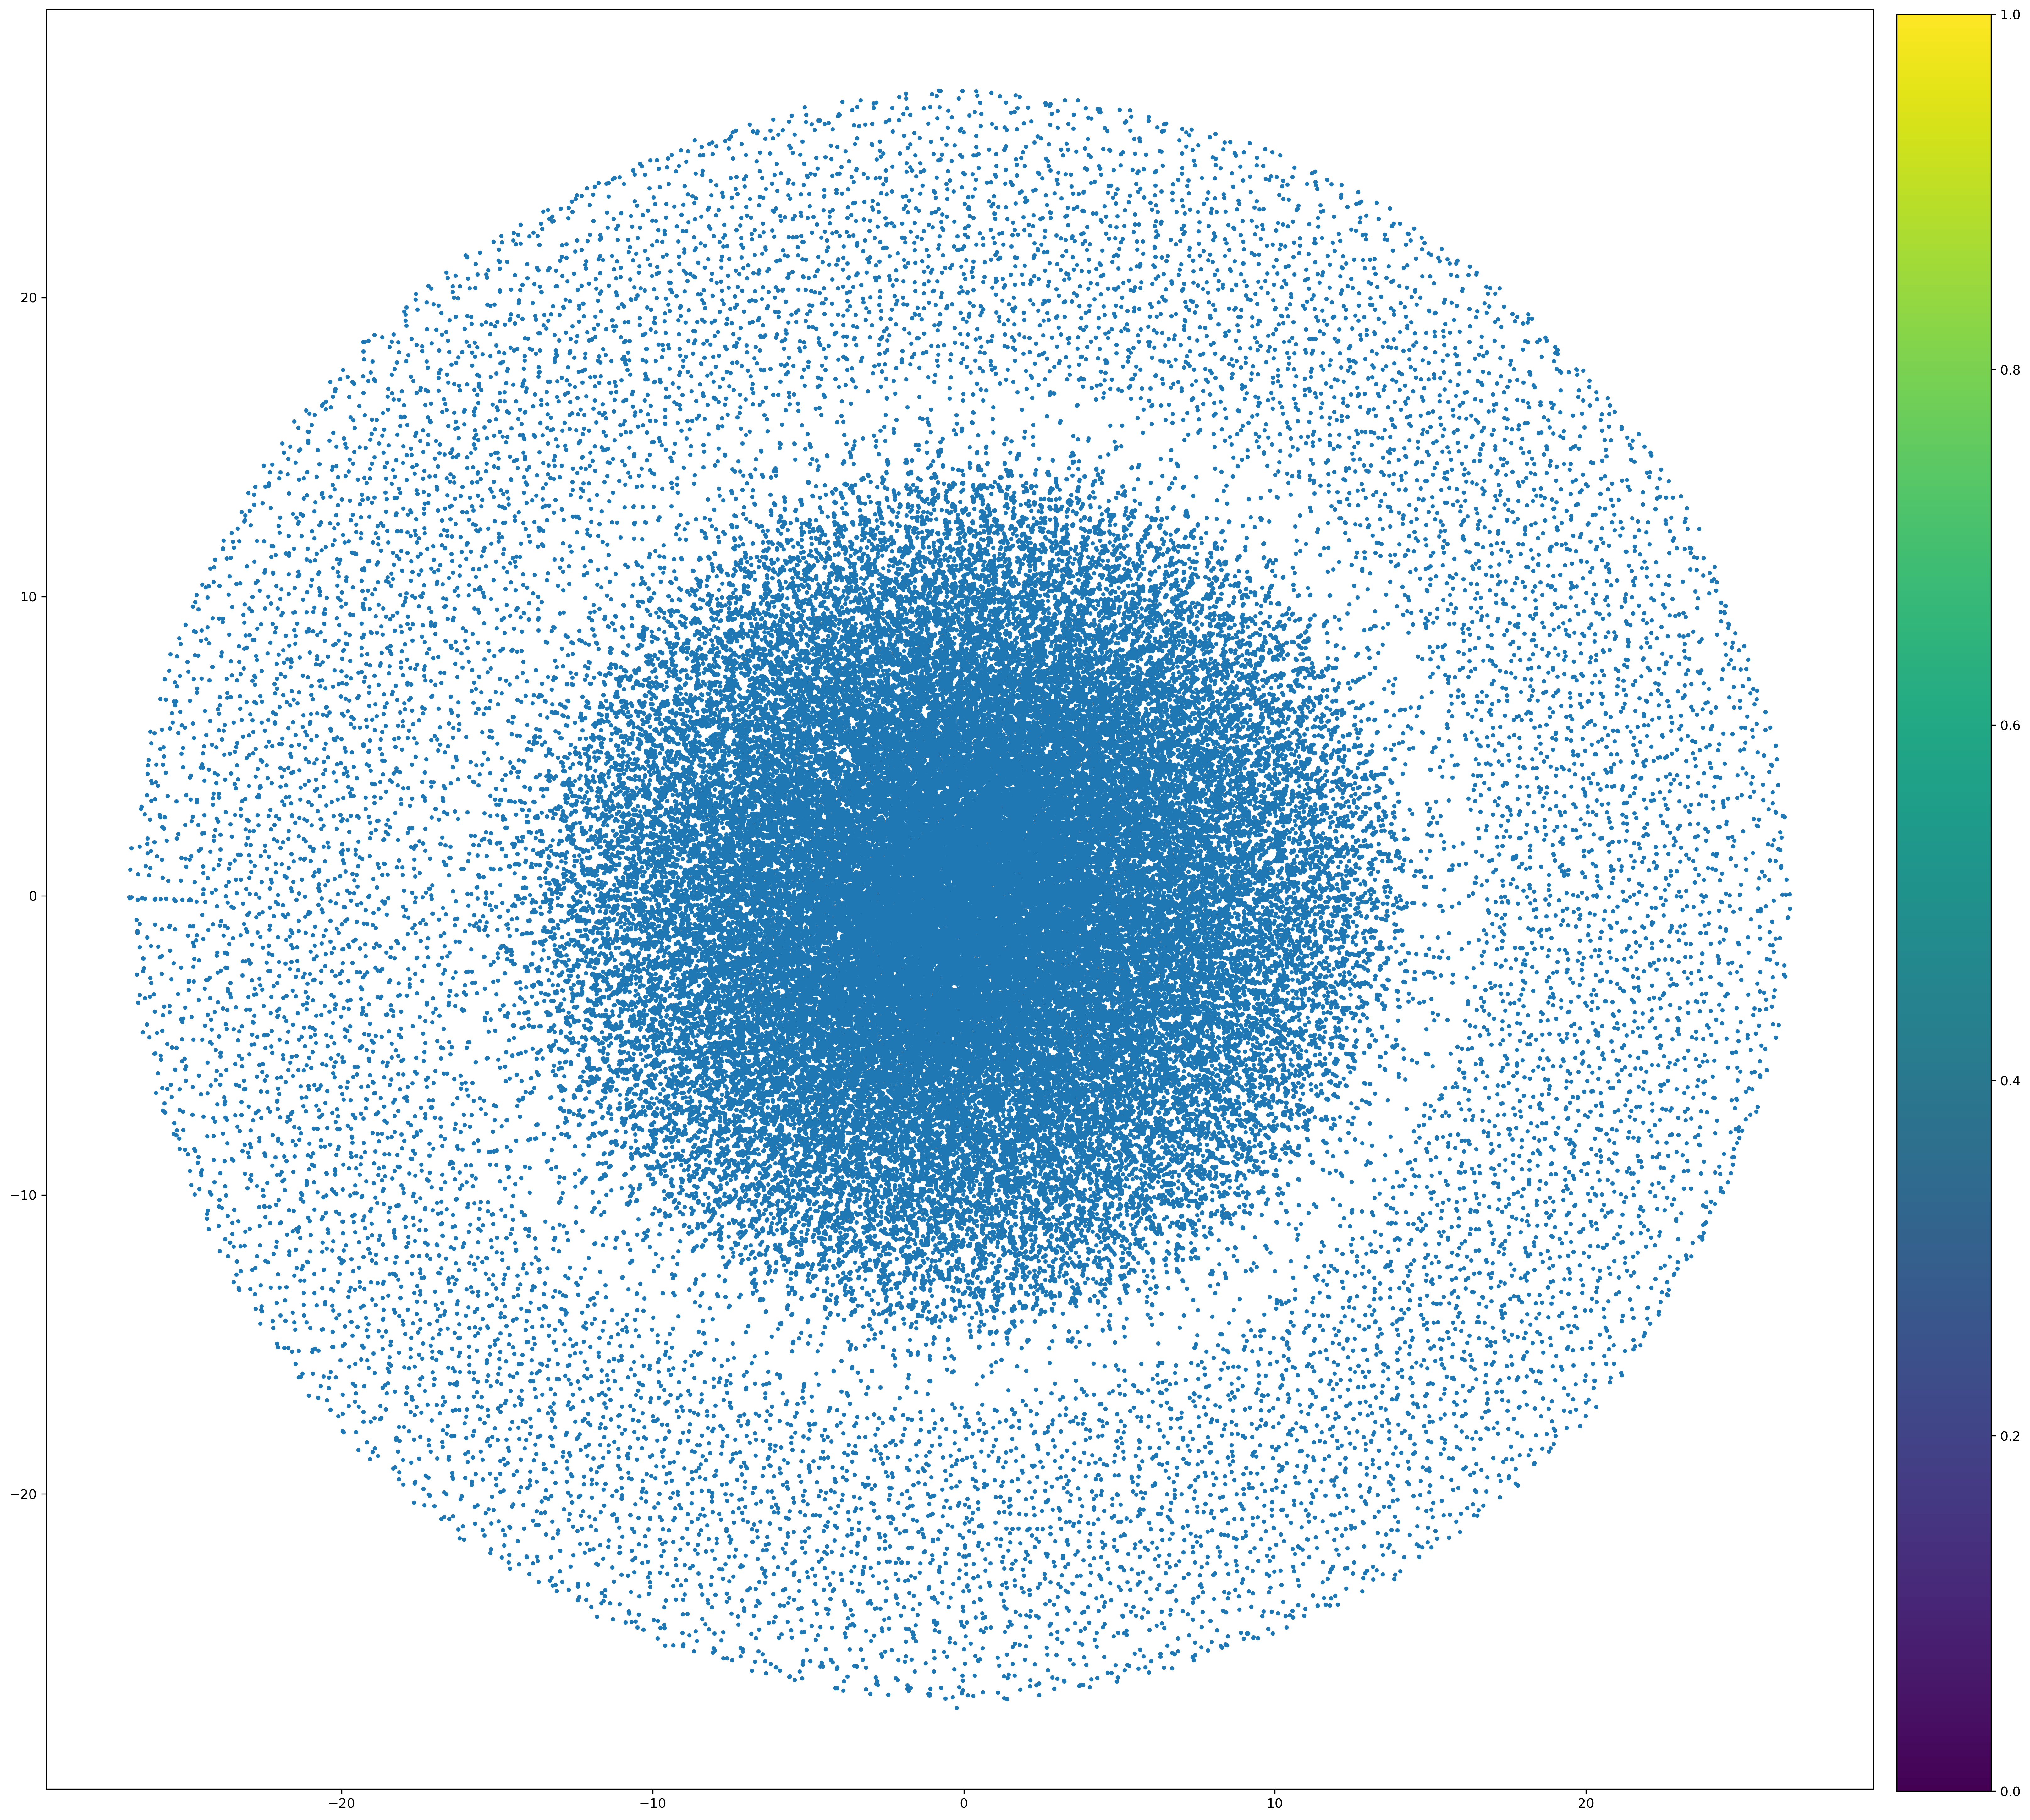

In [25]:

fig, ax = plt.subplots()
# cm = plt.cm.get_cmap('RdYlBu') 
cm = plt.cm.get_cmap('cividis') 

# cm = plt.cm.get_cmap('YlGnBu')
# plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(25, 25), dpi= 300, facecolor='w', edgecolor='k')

# sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=logp_qeds.cQED, cmap=cm, s=5) # show druglikeness
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5) # no colour / qed/logp

# sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data.validMolecule[0:10000], cmap=cm) # show valid molecules
# plt.xticks([])
# plt.yticks([])

# plt.xlim(-4,4)
# plt.ylim(-4,4)
# im = plt.contourf(x,y,Z)

cb_ax = fig.add_axes([.91,.124,.04,.754])
fig.colorbar(sc,orientation='vertical',cax=cb_ax)
# plt.clim(0.7,1)
plt.show()
fig.savefig("tsne.png")

### Save T-SNE data

In [ ]:
with open('tsne_data.pickle', 'wb') as handle:
    pickle.dump(X_tsne, handle, protocol=pickle.HIGHEST_PROTOCOL)


## LogP/QED data for 50k MOSES molecules

In [135]:
print(data.shape)

(1936962, 3)


In [22]:
import pickle
# logp_qeds = pickle.load( open("moses_cQed_cLogp.pkl", "rb" ) )
logp_qed = pickle.load( open("250k_smiles_stats.pkl", "rb" ) )

logp_qeds = logp_qed[0:10000]
logp_qeds = np.concatenate((logp_qeds, logp_qed[249455:,]))
# logp_qeds = pd.read_csv("moses_new.csv")
# filename = 'moses_new.csv'
# logp_qeds = pd.read_csv(filename)
# logp_qeds = logp_qeds[0:40000]

TypeError: '(slice(249455, None, None),)' is an invalid key

### Unused code for sampling latent space, VAE specific

In [ ]:
num_samples = 15
grid_x = np.linspace(-4, 4, num_samples)
grid_y = np.linspace(-4, 4, num_samples)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        smiles = outToSMILES(x_decoded)
        print(smiles)
        # digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        # figure[i * img_width: (i + 1) * img_width,
                # j * img_height: (j + 1) * img_height] = digit

## PCA of latent space

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

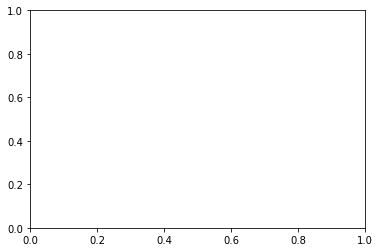

In [67]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')


pca = PCA(n_components = 2)
x_pca = pca.fit_transform(x)

plt.figure(figsize=(14, 20), dpi = 600)

# sc = plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='.', c=logp_qeds.clogP[0:30000], s=12, cmap=cm)
sc = plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='.', s=12)

cb_ax = fig.add_axes([.91,.124,.04,.754])
fig.savefig("pca.png")
fig.colorbar(sc,orientation='vertical',cax=cb_ax)

plt.show()

In [ ]:
# Plot loss

#plt.matshow(smiles_onehot[5].T)
# plt.yscale("log")
plt.plot(h.history["loss"], label="Loss")
# plt.yscale("log")

# Vanilla autoencoder
1. Mean squared error loss
2. Reaches ~0.99 accuracy

In [ ]:
import keras 
original_dim = (x_test.shape[1], x_test.shape[2])
# original_dim = (28, 28)

input_shape = (original_dim, )
intermediate_dim = 2048
latent_dim = 1024 # with 10k
batch_size = 32
epochs = 200
epsilon_std = 1.0
print(original_dim)
SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
    'o', 'n', 'p', 's', 'r'
]
max_length = len(SMILE_CHARSET)+1

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mu, z_log_var = args = args
    batch = K.shape(z_mu)[0]
    dim = K.int_shape(z_mu)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mu + K.exp(0.5 * z_log_var) * epsilon


K.clear_session()
tf.reset_default_graph() 
K.set_learning_phase(1)

# encoder: CNN
E_Input = Input(shape=(original_dim), name="encoder_input")
E_Conv0 = Convolution1D(9, 9, activation = 'relu', name='conv_1')(E_Input)
E_Conv1 = Convolution1D(9, 9, activation = 'relu', name='conv_2')(E_Conv0)
E_Conv2 = Convolution1D(10, 11, activation = 'relu', name='conv_3')(E_Conv1)

E_F = Flatten(name='flatten_1')(E_Conv2)
E_Output = Dense(latent_dim, activation = 'relu', name='dense_1')(E_F)

# uncomment when using VAE
# z_mu = Dense(latent_dim, name='z_mean')(E_Output)
# z_log_var = Dense(latent_dim, name='z_log_var')(E_Output)
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var])


# decoder: GRU
D_Input = Input(shape=(latent_dim,), name = "decoder_input") # Contains latents
D_RV = RepeatVector(x_train.shape[1], name='repeat_vector')(D_Input)
D_G0 = GRU(501, return_sequences = True, name='gru_1')(D_RV)
D_G1 = GRU(501, return_sequences = True, name='gru_2')(D_G0)
D_G2 = GRU(501, return_sequences = True, name='gru_3')(D_G1)
D_G3 = GRU(501, return_sequences = True, name='gru_3')(D_G2)

D_Output = TimeDistributed(Dense(x_train.shape[2], activation='softmax'), name = 'decoded_mean')(D_G3)

# Encoder = Model(E_Input, E_Output, name="encoder")
Encoder = Model(E_Input, E_Output, name="encoder")

Decoder = Model(D_Input, D_Output, name = "decoder")
print(Decoder.summary())
x_pred = Decoder(Encoder(E_Input))
# x_pred = Decoder(Encoder(E_Input)[2]) # VAE only

# not using VAE loss
# def vae_loss(x, x_decoded_mean):
#     x = K.flatten(x)
#     x_decoded_mean = K.flatten(x_decoded_mean)
#     xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
#     kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mu) - K.exp(z_log_var), axis = -1)
#     return xent_loss + kl_loss


vae = Model(inputs=E_Input, outputs=x_pred)
print(vae.summary())

from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=10, min_lr=0.000000001, verbose=1, epsilon=1e-5)
from keras.callbacks import ModelCheckpoint, CSVLogger

filepath="vaemodels/test/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('drive/My Drive/vae_logs/training.csv')

callbacks_list = [checkpoint, h, rlr, csv_logger]

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(loss="mean_squared_error", optimizer=opt, metrics = ['accuracy'])
print(vae.summary())
# print(Decoder.summary())
# print(Encoder.summary())

vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                callbacks = callbacks_list,
                validation_data=(x_test, x_test))



# https://stackoverflow.com/questions/54664338/keras-how-to-load-a-model-having-two-outputs-and-a-custom-loss-function